In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.cluster import KMeans

from IPython.display import clear_output
import time

from sklearn.linear_model import LinearRegression as lr
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', None)

In [2]:
pd.set_option('display.max_columns', None)

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.simplefilter('ignore')

colors = ['orange', 'darkblue', 'yellow', 'darkred', 'darkgreen', 'purple', 'lightgreen', 'pink', 'black', 'lightblue']*5     # Colors to differentiate clusters

# Loading Data

In [3]:
data = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Final Data\\gym_neighborhood_data.csv')

In [4]:
area = data['Km2'].copy()

In [5]:
cols = data.columns.tolist()

# Feature Engineering

In [6]:
data['adult pop'] = data[data.columns.tolist()[23:29]].sum(axis=1)

In [7]:
data['adult_pop/Km2'] = data['adult pop'] / data['Km2']

# Feature Selection: Population

In [8]:
pop = data[['neighborhood', 'adult pop', 'adult_pop/Km2', 'target pop', 'target_pop/Km2', 'Km2']].set_index('neighborhood').copy()

# Data Transformation

In [141]:
pop2 = (pop['target pop']**2/pop['Km2']).to_frame().copy()

In [142]:
pop_log2 = pop2.apply(np.log1p)

pop_ss2 = ss().fit_transform(pop_log2)
pop_mms2 = mms().fit_transform(pop_log2)

# Feature Definition

In [143]:
xs = pop[['target pop']]
ys = pop[['Km2']]
zs = pop[['target_pop/Km2']]
ws = pop[['adult pop']]
ks = pop[['adult_pop/Km2']]


xs_poly = pd.DataFrame(pf(degree=2).fit_transform(xs), index=xs.index)
ys_poly = pd.DataFrame(pf(degree=2).fit_transform(ys), index=ys.index)
ws_poly = pd.DataFrame(pf(degree=2).fit_transform(ws), index=ws.index)

xs_inv = pd.concat([xs, 1/xs], axis=1)
ys_inv = pd.concat([ys, 1/ys], axis=1)

# Fitting Clusters

In [579]:
    kmeans = KMeans(n_clusters=28, n_init=100)
    kmeans.fit(pop_ss2)
    pop['cluster'] = kmeans.labels_
    
    clusters = pop['cluster']
    sorted_clusters = pop.groupby('cluster').mean()['target_pop/Km2'].sort_values().index

    x_i = [xs[clusters==cluster] for cluster in sorted_clusters]
    y_i = [ys[clusters==cluster] for cluster in sorted_clusters]
    z_i = [zs[clusters==cluster] for cluster in sorted_clusters]
    w_i = [ws[clusters==cluster] for cluster in sorted_clusters]
    k_i = [ks[clusters==cluster] for cluster in sorted_clusters]

# Clusters Regressions

In [580]:
    #-------- Regression --------------
    
    a1_i, b1_i, c1_i = [], [], []
    a2_i, b2_i, c2_i = [], [], []
    a3_i, b3_i, c3_i = [], [], []
    a4_i, b4_i, c4_i = [], [], []
    a5_i, b5_i, c5_i = [], [], []
    a6_i, b6_i, c6_i = [], [], []
    a7_i, b7_i, c7_i = [], [], []
    a8_i, b8_i, c8_i = [], [], []
    
    for cluster in sorted_clusters:
        
        lre = lr().fit(ys_poly[clusters==cluster], xs[clusters==cluster])    # 1. x(y) = a1*y² + b1*y + c1

        a1_i.append(lre.coef_[0][1])
        b1_i.append(lre.coef_[0][2])
        c1_i.append(lre.intercept_[0])
            
        lre = lr().fit(ws[clusters==cluster], xs[clusters==cluster])  # 2. x(w) = a2*w + b2

        a2_i.append(lre.coef_[0][0])
        b2_i.append(lre.intercept_[0])
        
        lre = lr().fit(xs_poly[clusters==cluster], ys[clusters==cluster])  # 3. y(x) = a3*x² + b3*x + c3
                
        a3_i.append(lre.coef_[0][1])
        b3_i.append(lre.coef_[0][2])
        c3_i.append(lre.intercept_[0])
            
        lre = lr().fit(ws_poly[clusters==cluster], ys[clusters==cluster])  # 4. y(w) = a4*w² + b4*w + c4
        
        a4_i.append(lre.coef_[0][1])
        b4_i.append(lre.coef_[0][2])
        c4_i.append(lre.intercept_[0])

        lre = lr().fit(xs[clusters==cluster], ws[clusters==cluster])  # 5. w(x) = a5x + b5

        a5_i.append(lre.coef_[0][0])
        b5_i.append(lre.intercept_[0])
        
        lre = lr().fit(ys_poly[clusters==cluster], ws[clusters==cluster])  # 6. w(y) = a6*y² + b6*y + c6
        
        a6_i.append(lre.coef_[0][1])
        b6_i.append(lre.coef_[0][2])
        c6_i.append(lre.intercept_[0])

        lre = lr().fit(xs_inv[clusters==cluster], 1/zs[clusters==cluster])  # 7. 1/z(x) = a7*x + b7/x + c7
        
        a7_i.append(lre.coef_[0][0])
        b7_i.append(lre.coef_[0][1])
        c7_i.append(lre.intercept_[0])

        lre = lr().fit(ys_inv[clusters==cluster], zs[clusters==cluster])  # 8. z(y) = a8*y + b8/y + c8
        
        a8_i.append(lre.coef_[0][0])
        b8_i.append(lre.coef_[0][1])
        c8_i.append(lre.intercept_[0])
        
        
    #--------- Predictions ------------

    x1_i = [np.linspace(xs[clusters==cluster].min(), xs[clusters==cluster].max(), 100) for cluster in sorted_clusters]
    y1_i = [np.linspace(ys[clusters==cluster].min(), ys[clusters==cluster].max(), 100) for cluster in sorted_clusters]
    z1_i = [np.linspace(zs[clusters==cluster].min(), zs[clusters==cluster].max(), 100) for cluster in sorted_clusters]
    w1_i = [np.linspace(ws[clusters==cluster].min(), ws[clusters==cluster].max(), 100) for cluster in sorted_clusters]
    k1_i = [np.linspace(ks[clusters==cluster].min(), ks[clusters==cluster].max(), 100) for cluster in sorted_clusters]
    
    xy_pred_i = [a1*(ys_poly[clusters==cluster].iloc[:,1]) + b1*(ys_poly[clusters==cluster].iloc[:,2]) + c1 for a1, b1, c1, cluster in zip(a1_i, b1_i, c1_i, sorted_clusters)]   # 1. x(y) = a1*y² + b1*y + c1
    xy_pred_i_grid = [a1*(y1) + b1*(y1**2) + c1 for a1, b1, c1, y1 in zip(a1_i, b1_i, c1_i, y1_i)]
    
    xw_pred_i = [a2*(ws[clusters==cluster].iloc[:,0]) + b2 for a2, b2, cluster in zip(a2_i, b2_i, sorted_clusters)]      # 2. x(w) = a2*w + b2
    xw_pred_i_grid = [a2*(w1) + b2 for a2, b2, w1 in zip(a2_i, b2_i, w1_i)]

    yx_pred_i = [a3*(xs_poly[clusters==cluster].iloc[:,1]) + b3*(xs_poly[clusters==cluster].iloc[:,2]) + c3 for a3, b3, c3, cluster in zip(a3_i, b3_i, c3_i, sorted_clusters)]     # 3. y(x) = a3*x² + b3*x + c3
    yx_pred_i_grid = [a3*(x1) + b3*(x1**2) + c3 for a3, b3, c3, x1 in zip(a3_i, b3_i, c3_i, x1_i)]

    yw_pred_i = [a4*(ws_poly[clusters==cluster].iloc[:,1]) + b4*(ws_poly[clusters==cluster].iloc[:,2]) + c4 for a4, b4, c4, cluster in zip(a4_i, b4_i, c4_i, sorted_clusters)]   # 4. y(w) = a4*w² + b4*w + c4
    yw_pred_i_grid = [a4*(w1) + b4*(w1**2) + c4 for a4, b4, c4, w1 in zip(a4_i, b4_i, c4_i, w1_i)]
    
    wx_pred_i = [a5*(xs[clusters==cluster].iloc[:,0]) + b5 for a5, b5, cluster in zip(a5_i, b5_i, sorted_clusters)]      # 5. w(x) = a5x + b5
    wx_pred_i_grid = [a5*(x1) + b5 for a5, b5, x1 in zip(a5_i, b5_i, x1_i)] 

    wy_pred_i = [a6*(ys_poly[clusters==cluster].iloc[:,1]) + b6*(ys_poly[clusters==cluster].iloc[:,2]) + c6 for a6, b6, c6, cluster in zip(a6_i, b6_i, c6_i, sorted_clusters)]     # 6. w(y) = a6*y² + b6*y + c6
    wy_pred_i_grid = [a6*(y1) + b6*(y1**2) + c6 for a6, b6, c6, y1 in zip(a6_i, b6_i, c6_i, y1_i)]

    zx_pred_i = [1 / (a7*(xs_inv[clusters==cluster].iloc[:,0]) + b7*(xs_inv[clusters==cluster].iloc[:,1]) + c7) for a7, b7, c7, cluster in zip(a7_i, b7_i, c7_i, sorted_clusters)]     # 7. 1/z(x) = a7*x + b7/x + c7
    zx_pred_i_grid = [1 / (a7*(x1) + b7*(1/x1) + c7) for a7, b7, c7, x1 in zip(a7_i, b7_i, c7_i, x1_i)]
    
    zy_pred_i = [(a8*(ys_inv[clusters==cluster].iloc[:,0]) + b8*(ys_inv[clusters==cluster].iloc[:,1]) + c8) for a8, b8, c8, cluster in zip(a8_i, b8_i, c8_i, sorted_clusters)]     # 8. z(y) = a8*y + b8/y + c8
    zy_pred_i_grid = [(a8*(y1) + b8*(1/y1) + c8) for a8, b8, c8, y1 in zip(a8_i, b8_i, c8_i, y1_i)]
 


    xy_pred_i = [a1*(ys_poly[clusters==cluster].iloc[:,1]) + b1*(ys_poly[clusters==cluster].iloc[:,2]) + c1 for a1, b1, c1, cluster in zip(a1_i, b1_i, c1_i, sorted_clusters)]   # 1. x(y) = a1*y² + b1*y + c1
    xw_pred_i = [a2*(ws[clusters==cluster].iloc[:,0]) + b2 for a2, b2, cluster in zip(a2_i, b2_i, sorted_clusters)]      # 2. x(w) = a2*w + b2
    yx_pred_i = [a3*(xs_poly[clusters==cluster].iloc[:,1]) + b3*(xs_poly[clusters==cluster].iloc[:,2]) + c3 for a3, b3, c3, cluster in zip(a3_i, b3_i, c3_i, sorted_clusters)]     # 3. y(x) = a3*x² + b3*x + c3
    yw_pred_i = [a4*(ws_poly[clusters==cluster].iloc[:,1]) + b4*(ws_poly[clusters==cluster].iloc[:,2]) + c4 for a4, b4, c4, cluster in zip(a4_i, b4_i, c4_i, sorted_clusters)]   # 4. y(w) = a4*w² + b4*w + c4
    wx_pred_i = [a5*(xs[clusters==cluster].iloc[:,0]) + b5 for a5, b5, cluster in zip(a5_i, b5_i, sorted_clusters)]      # 5. w(x) = a5x + b5
    wy_pred_i = [a6*(ys_poly[clusters==cluster].iloc[:,1]) + b6*(ys_poly[clusters==cluster].iloc[:,2]) + c6 for a6, b6, c6, cluster in zip(a6_i, b6_i, c6_i, sorted_clusters)]     # 6. w(y) = a6*y² + b6*y + c6
    zx_pred_i = [1 / (a7*(xs_inv[clusters==cluster].iloc[:,0]) + b7*(xs_inv[clusters==cluster].iloc[:,1]) + c7) for a7, b7, c7, cluster in zip(a7_i, b7_i, c7_i, sorted_clusters)]     # 7. 1/z(x) = a7*x + b7/x + c7
    zy_pred_i = [(a8*(ys_inv[clusters==cluster].iloc[:,0]) + b8*(ys_inv[clusters==cluster].iloc[:,1]) + c8) for a8, b8, c8, cluster in zip(a8_i, b8_i, c8_i, sorted_clusters)]     # 8. z(y) = a8*y + b8/y + c8
    
    
    xy_pred_i_grid = [a1*(y1) + b1*(y1**2) + c1 for a1, b1, c1, y1 in zip(a1_i, b1_i, c1_i, y1_i)]
    xw_pred_i_grid = [a2*(w1) + b2 for a2, b2, w1 in zip(a2_i, b2_i, w1_i)]    
    yx_pred_i_grid = [a3*(x1) + b3*(x1**2) + c3 for a3, b3, c3, x1 in zip(a3_i, b3_i, c3_i, x1_i)]    
    yw_pred_i_grid = [a4*(w1) + b4*(w1**2) + c4 for a4, b4, c4, w1 in zip(a4_i, b4_i, c4_i, w1_i)]
    wx_pred_i_grid = [a5*(x1) + b5 for a5, b5, x1 in zip(a5_i, b5_i, x1_i)] 
    wy_pred_i_grid = [a6*(y1) + b6*(y1**2) + c6 for a6, b6, c6, y1 in zip(a6_i, b6_i, c6_i, y1_i)]
    zx_pred_i_grid = [1 / (a7*(x1) + b7*(1/x1) + c7) for a7, b7, c7, x1 in zip(a7_i, b7_i, c7_i, x1_i)]
    zy_pred_i_grid = [(a8*(y1) + b8*(1/y1) + c8) for a8, b8, c8, y1 in zip(a8_i, b8_i, c8_i, y1_i)]

    
        # ------------- Indirectly Predicted  ------------
    
    zx2_pred_i = [xs_poly[clusters==cluster].iloc[:,1] / yx_pred_i[i] for i, cluster in enumerate(sorted_clusters)]         # 9. z(x) = x / (a3*x² + b3*x + c3)
    zy2_pred_i = [xy_pred_i[i] / ys_poly[clusters==cluster].iloc[:,1] for i, cluster in enumerate(sorted_clusters)]         # 10. z(y) = a1*y + b1/y + c1  OR  z(y) = xy_pred/y

    zx2_pred_i_grid = [x1 / (a3*(x1) + b3*(x1**2) + c3) for a3, b3, c3, x1 in zip(a3_i, b3_i, c3_i, x1_i)]    
    zy2_pred_i_grid = [(a1*(y1) + b1*(y1**2) + c1) / y1 for a1, b1, c1, y1 in zip(a1_i, b1_i, c1_i, y1_i)]    
    
    #------------------   Full Grid  -----------
    
    x2_i = [np.linspace(xs.min(), xs.max(), 100) for cluster in sorted_clusters]
    y2_i = [np.linspace(ys.min(), ys.max(), 100) for cluster in sorted_clusters]
    z2_i = [np.linspace(zs.min(), zs.max(), 100) for cluster in sorted_clusters]
    w2_i = [np.linspace(ws.min(), ws.max(), 100) for cluster in sorted_clusters]
    k2_i = [np.linspace(ks.min(), ks.max(), 100) for cluster in sorted_clusters]

    
    xy_pred_i_grid2 = [a1*(y2) + b1*(y2**2) + c1 for a1, b1, c1, y2 in zip(a1_i, b1_i, c1_i, y2_i)]
    xw_pred_i_grid2 = [a2*(w2) + b2 for a2, b2, w2 in zip(a2_i, b2_i, w2_i)]    
    yx_pred_i_grid2 = [a3*(x2) + b3*(x2**2) + c3 for a3, b3, c3, x2 in zip(a3_i, b3_i, c3_i, x2_i)]    
    yw_pred_i_grid2 = [a4*(w2) + b4*(w2**2) + c4 for a4, b4, c4, w2 in zip(a4_i, b4_i, c4_i, w2_i)]
    wx_pred_i_grid2 = [a5*(x2) + b5 for a5, b5, x2 in zip(a5_i, b5_i, x2_i)] 
    wy_pred_i_grid2 = [a6*(y2) + b6*(y2**2) + c6 for a6, b6, c6, y2 in zip(a6_i, b6_i, c6_i, y2_i)]
    zx_pred_i_grid2 = [1 / (a7*(x2) + b7*(1/x2) + c7) for a7, b7, c7, x2 in zip(a7_i, b7_i, c7_i, x2_i)]
    zy_pred_i_grid2 = [(a8*(y2) + b8*(1/y2) + c8) for a8, b8, c8, y2 in zip(a8_i, b8_i, c8_i, y2_i)]
    zx2_pred_i_grid2 = [x2 / (a3*(x2) + b3*(x2**2) + c3) for a3, b3, c3, x2 in zip(a3_i, b3_i, c3_i, x2_i)]    
    zy2_pred_i_grid2 = [(a1*(y2) + b1*(y2**2) + c1) / y2 for a1, b1, c1, y2 in zip(a1_i, b1_i, c1_i, y2_i)]    
    



# Clusters Visualization

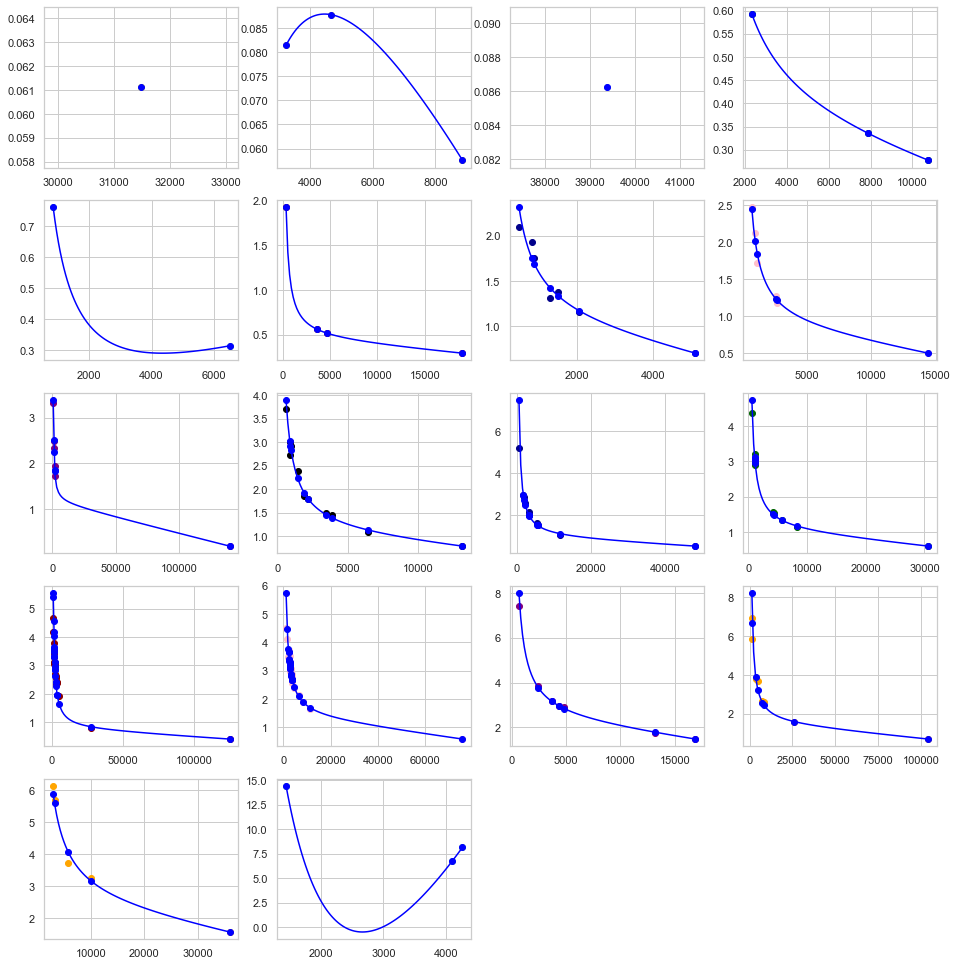

In [36]:
#---- Plotting ----        
#control=input('Insert variable: ')
mode = input('Insert Mode (Dinamic or Static-Default) :')

for control in ['xy', 'xw', 'yx', 'yw', 'wy', 'zx', 'zy', 'zx2', 'zy2']:
        
    stop=input('To exit insert "exit": ')
    
    if stop=='exit': break
    clear_output(wait=True)
    
    if mode=='dinamic':
        fig = plt.figure(figsize=(16, 42))
        axes = [fig.add_subplot(12,4,i) for i in range(1,len(pop['cluster'].unique())+1)]
    else:
        fig = plt.figure(figsize=(14, 13))
        ax0 = fig.add_subplot(2,1,1)
        ax1 = fig.add_subplot(2,1,2)
   
        if control=='xy':
            ax1.set_xlim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/3)
            ax1.set_ylim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/5)
        elif control=='xw':
            ax1.set_xlim(ws.iloc[:,0].min(), ws.iloc[:,0].max()/3)
            ax1.set_ylim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/3)
        elif control=='yx':
            ax1.set_xlim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/6)
            ax1.set_ylim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/3)
        elif control=='yw':
            ax1.set_xlim(ws.iloc[:,0].min(), ws.iloc[:,0].max()/3)
            ax1.set_ylim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/3)
        elif control=='wx':
            ax1.set_xlim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/3)
            ax1.set_ylim(ws.iloc[:,0].min(), ws.iloc[:,0].max()/3)
        elif control=='wy':
            ax1.set_xlim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/6)
            ax1.set_ylim(ws.iloc[:,0].min(), ws.iloc[:,0].max()/3)
        elif control=='zx':
            ax1.set_xlim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/3)
            ax1.set_ylim(zs.iloc[:,0].min(), zs.iloc[:,0].max()/3)
        elif control=='zy':
            ax1.set_xlim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/3)
            ax1.set_ylim(zs.iloc[:,0].min(), zs.iloc[:,0].max()/3)
        elif control=='zx2':
            ax1.set_xlim(xs.iloc[:,0].min(), xs.iloc[:,0].max()/3)
            ax1.set_ylim(zs.iloc[:,0].min(), zs.iloc[:,0].max()/3)
        elif control=='zy2':
            ax1.set_xlim(ys.iloc[:,0].min(), ys.iloc[:,0].max()/3)
            ax1.set_ylim(zs.iloc[:,0].min(), zs.iloc[:,0].max()/3)
   
    for i, cluster in enumerate(sorted_clusters):
        
        if control=='xy':
            
            if mode=='dinamic':
                axes[i].scatter(ys[clusters==cluster], xs[clusters==cluster], color=colors[i])
                axes[i].scatter(ys[clusters==cluster], xy_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(y1_i[i], xy_pred_i_grid[i].ravel(), color='blue')
            else:
                ax0.scatter(ys[clusters==cluster], xs[clusters==cluster], color=colors[i], s=18)
                ax0.scatter(ys[clusters==cluster], xy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(y1_i[i], xy_pred_i_grid[i].ravel(), color=colors[i])
            
                ax1.scatter(ys[clusters==cluster], xs[clusters==cluster], color=colors[i], s=18)
                ax1.scatter(ys[clusters==cluster], xy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(y1_i[i], xy_pred_i_grid[i].ravel(), color=colors[i])
        
        elif control=='xw':

            if mode=='dinamic':  
                axes[i].scatter(ws[clusters==cluster], xs[clusters==cluster], color=colors[cluster])
                axes[i].scatter(ws[clusters==cluster], xw_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(w1_i[i], xw_pred_i_grid[i].ravel(), color='blue')
            else:
                ax0.scatter(ws[clusters==cluster], xs[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(ws[clusters==cluster], xw_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(w1_i[i], xw_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(ws[clusters==cluster], xs[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(ws[clusters==cluster], xw_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(w1_i[i], xw_pred_i_grid[i].ravel(), color=colors[cluster])
        
        elif control=='yx':

            if mode=='dinamic':
                axes[i].scatter(xs[clusters==cluster], ys[clusters==cluster], color=colors[cluster])
                axes[i].scatter(xs[clusters==cluster], yx_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(x1_i[i], yx_pred_i_grid[i].ravel(), color='blue')
            else:
                ax0.scatter(xs[clusters==cluster], ys[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(xs[clusters==cluster], yx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(x1_i[i], yx_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(xs[clusters==cluster], ys[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(xs[clusters==cluster], yx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(x1_i[i], yx_pred_i_grid[i].ravel(), color=colors[cluster])
        
        elif control=='yw':

            if mode=='dinamic':            
                axes[i].scatter(ws[clusters==cluster], ys[clusters==cluster], color=colors[cluster])
                axes[i].scatter(ws[clusters==cluster], yw_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(w1_i[i], yw_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(ws[clusters==cluster], ys[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(ws[clusters==cluster], yw_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(w1_i[i], yw_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(ws[clusters==cluster], ys[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(ws[clusters==cluster], yw_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(w1_i[i], yw_pred_i_grid[i].ravel(), color=colors[cluster])

        elif control=='wx':

            if mode=='dinamic':            
                axes[i].scatter(xs[clusters==cluster], ws[clusters==cluster], color=colors[cluster])
                axes[i].scatter(xs[clusters==cluster], wx_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(x1_i[i], wx_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(xs[clusters==cluster], ws[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(xs[clusters==cluster], wx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(x1_i[i], wx_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(xs[clusters==cluster], ws[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(xs[clusters==cluster], wx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(x1_i[i], wx_pred_i_grid[i].ravel(), color=colors[cluster])
        
        elif control=='wy':

            if mode=='dinamic':            
                axes[i].scatter(ys[clusters==cluster], ws[clusters==cluster], color=colors[cluster])
                axes[i].scatter(ys[clusters==cluster], wy_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(y1_i[i], wy_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(ys[clusters==cluster], ws[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(ys[clusters==cluster], wy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(y1_i[i], wy_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(ys[clusters==cluster], ws[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(ys[clusters==cluster], wy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(y1_i[i], wy_pred_i_grid[i].ravel(), color=colors[cluster])
        
        elif control=='zx':

            if mode=='dinamic':            
                axes[i].scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster])
                axes[i].scatter(xs[clusters==cluster], zx_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(x1_i[i], zx_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(xs[clusters==cluster], zx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(x1_i[i], zx_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(xs[clusters==cluster], zx_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(x1_i[i], zx_pred_i_grid[i].ravel(), color=colors[cluster])
               
        elif control=='zy':

            if mode=='dinamic':            
                axes[i].scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster])
                axes[i].scatter(ys[clusters==cluster], zy_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(y1_i[i], zy_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(ys[clusters==cluster], zy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(y1_i[i], zy_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(ys[clusters==cluster], zy_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(y1_i[i], zy_pred_i_grid[i].ravel(), color=colors[cluster])

        elif control=='zx2':

            if mode=='dinamic':            
                axes[i].scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster])
                axes[i].scatter(xs[clusters==cluster], zx2_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(x1_i[i], zx2_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(xs[clusters==cluster], zx2_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(x1_i[i], zx2_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(xs[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(xs[clusters==cluster], zx2_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(x1_i[i], zx2_pred_i_grid[i].ravel(), color=colors[cluster])
               
        elif control=='zy2':

            if mode=='dinamic':            
                axes[i].scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster])
                axes[i].scatter(ys[clusters==cluster], zy2_pred_i[i].values.ravel(), color='blue')
                axes[i].plot(y1_i[i], zy2_pred_i_grid[i].ravel(), color='blue')
            
            else:
                ax0.scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax0.scatter(ys[clusters==cluster], zy2_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax0.plot(y1_i[i], zy2_pred_i_grid[i].ravel(), color=colors[cluster])
            
                ax1.scatter(ys[clusters==cluster], zs[clusters==cluster], color=colors[cluster], s=18)
                ax1.scatter(ys[clusters==cluster], zy2_pred_i[i].values.ravel(), color='grey', s=38, alpha=1)
                ax1.plot(y1_i[i], zy2_pred_i_grid[i].ravel(), color=colors[cluster])

 
    
    if mode!='dinamic':
        ax0.set_ylabel(control[0])
        ax0.set_xlabel(control[1])
        ax1.set_ylabel(control[0])
        ax1.set_xlabel(control[1])
    
    plt.show()
    plt.pause(0.001)
    
    

# Clusters Classification

## Train Test Split

In [581]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

In [588]:
less_2 = pop['cluster'].value_counts()[pop['cluster'].value_counts()<2].index

In [589]:
greater_2 = ~pop['cluster'].isin([less_2])

In [590]:
x = data.set_index('neighborhood')[greater_2].drop(['target pop', 'adult pop', 'target_pop/Km2', 'adult_pop/Km2'], axis=1)#.dropna(how='all', axis=0).copy()
x.fillna(0, inplace=True)
#for col in x:
 #   x[col].fillna(x[col].mean(), inplace=True)

In [591]:
y = pop['cluster'][greater_2].loc[x.index].copy()

In [592]:
x_log = x.apply(np.log1p)

x_ss = ss().fit_transform(x_log)

x_mms = mms().fit_transform(x_log)

In [593]:
splitter = sss(test_size=0.75, n_splits=1)

for test_index, train_index in splitter.split(x_ss, y):
    x_test, x_train = x.iloc[test_index], x.iloc[train_index]
    y_test, y_train = y.iloc[test_index], y.iloc[train_index]

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

y_test.value_counts()/(y_train.value_counts()+ y_test.value_counts())

(y_train.value_counts(), y_test.value_counts())

In [530]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [542]:
log_reg = LogisticRegression(penalty='l2', C=1)

In [543]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9)

KNeighborsClassifier?

In [545]:
log_reg.fit(x_train.values, y_train)

LogisticRegression(C=1)

In [546]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [ ]:
y_pred = log_reg.predict(x_test)

In [550]:
y_pred = tree.predict(x_test)

In [577]:
knn_scrs = []

for n_neighbors in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    knn_scrs.append([n_neighbors, accuracy_score(y_test, y_pred)])
    if n_neighbors in range(1,30,5): print(n_neighbors)
knn_scrs_df = pd.DataFrame(knn_scrs, columns=['n_neighbors', 'acc_scr'])

1
6
11
16
21
26


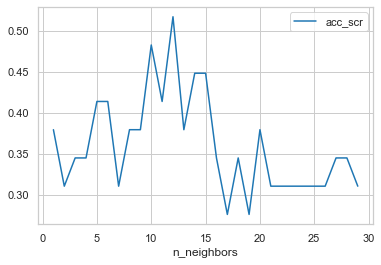

In [578]:
knn_scrs_df.plot('n_neighbors', 'acc_scr')

In [540]:
tree_scrs = []
for max_depth in range(1,150):
        
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    tree_scrs.append([max_depth, accuracy_score(y_test, y_pred), tree.feature_importances_, tree.max_features_, confusion_matrix(y_test, y_pred)])
    if max_depth in range(1,150,15): print(max_depth, 'Computed.')
    
tree_scrs_df = pd.DataFrame(tree_scrs, columns=['max_depth', 'acc_scr', 'feat_importances', 'max_feats', 'confusion_matrix'])

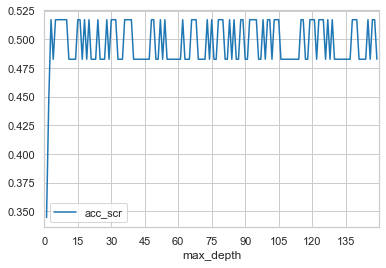

In [541]:
tree_scrs_df.plot(x='max_depth', y='acc_scr', xticks=range(0,150,15), xlim=(0,150))

In [516]:
tree_scrs_df.describe()

,max_depth,acc_scr,max_feats
count,19.000000,19.000000,19.0
mean,10.000000,0.676951,150.0
std,5.627314,0.129130,0.0
min,1.000000,0.344828,150.0
25%,5.500000,0.655172,150.0
50%,10.000000,0.689655,150.0
75%,14.500000,0.775862,150.0
max,19.000000,0.827586,150.0


In [523]:
feat_importance = tree_scrs_df.loc[4]['feat_importances']

In [524]:
feats = x_train.columns[feat_importance!=0].tolist()

<BarContainer object of 14 artists>

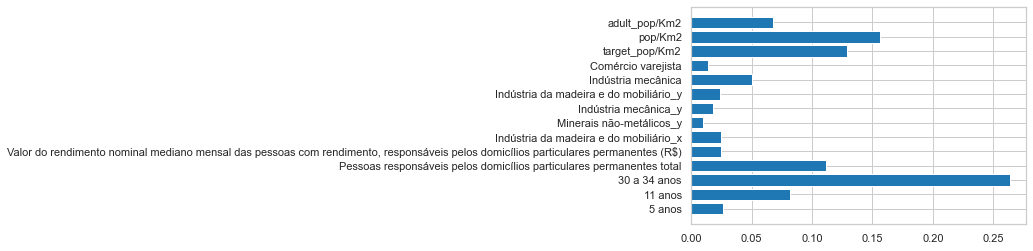

In [525]:
fig, ax0 = plt.subplots(1,1)

ax0.barh(feats, feat_importance[feat_importance!=0])